In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os

In [2]:
translation_dict = {
    'native-tls-hw-supp': 'Native TLS HW supp',
    'native-tls': 'Native TLS no HW supp',
    'native': 'Native (no TLS)',
    'wasm': 'WASM (no TLS)',
    'wasm-tls': 'WASM TLS',
    'sgx': 'WASM SGX (no TLS)',
    'sgx-tls': 'WASM SGX TLS',
    'qos0': 'QoS 0',
    'qos1': 'QoS 1',
    'qos2': 'QoS 2',
    'expected_delivered': 'Expected delivered messages / s',
    'delivered_messages': 'Delivered messages / s',
    'reliability': 'Delivery rate (%)',
    'latency': 'Latency (s)',
    'throughput': 'Throughput (Messages /s) [at min 95 % reliability]',
    'timestamp' : 'Time [s]',
    'messages' : 'Messages / s',
}

cases = ['native-tls', 'native-tls-hw-supp', 'native', 'wasm', 'wasm-tls', 'sgx', 'sgx-tls']
cases_tls = ['native-tls', 'wasm-tls', 'sgx-tls']
cases_no_tls = ['native', 'wasm', 'sgx']
cases_native = ['native-tls', 'native-tls-hw-supp', 'native']

cases = cases_tls

machine = 'grassen-1'
payload_size = None
import_base_bath = 'data/' + machine + '/'
if payload_size != None:
    import_base_bath += payload_size + '/'

export_base_path = 'export/' + machine + '/'
if payload_size != None:
    export_base_path += payload_size + '/'
os.makedirs(export_base_path, exist_ok=True)

In [3]:
number_publishers = 64
number_subscribers = 25
message_dict = {}
first_missing_ts_dict = {}
min_latency = {}
for case in cases:
    publisher_df = pd.DataFrame()
    msg_df = pd.DataFrame()
    for i in range(number_publishers):
        df = pd.read_csv(import_base_bath + 'results_' + case + '/' + str(i) + '.csv', sep = ';')
        if len(df) > 0:
            publisher_df = pd.concat([publisher_df, df])
    
    # only send events
    publisher_df = publisher_df[publisher_df['event'] == 3]
    publisher_df = publisher_df.sort_values(by=['timestamp']).rename(columns={'timestamp': 'timestamp_send'})
    publisher_df = publisher_df.drop(columns=['event'])

    subscriber_df = pd.DataFrame()
    for i in range(number_subscribers):
        df = pd.read_csv(import_base_bath + 'results_' + case + '/' + str(i + number_publishers) + '.csv', sep = ';')
        subscriber_df = pd.concat([subscriber_df, df])
        df = publisher_df.merge(df, on='payload', how='left')
        df = df.rename(columns={'timestamp': 'timestamp_receive'})
        msg_df = pd.concat([msg_df, df])

    
    # only receive events
    subscriber_df = subscriber_df[subscriber_df['event'] == 9]
    subscriber_df = subscriber_df.sort_values(by=['timestamp']).rename(columns={'timestamp': 'timestamp_receive'})
    subscriber_df = subscriber_df.drop(columns=['event'])
    
    print('Case: ' + case)
    print('Number of received messages: ' + str(len(subscriber_df)))
    print('Number of sent messages: ' + str(len(publisher_df)))

    
    df = pd.merge(subscriber_df, publisher_df, on='payload', how='outer')
    print('Number of lost messages: ' + str(len(msg_df) - len(subscriber_df)))
    missing = msg_df[msg_df['timestamp_receive'].isnull()]
    first_missing_ts_dict[case] = missing['timestamp_send'].min()
    print('\n')
    df = df.drop(columns=['payload'])

    df['latency'] = df['timestamp_receive'] - df['timestamp_send']
    min_latency[case] = df['latency'].min()

    message_dict[case] = df


Case: native-tls
Number of received messages: 3334565
Number of sent messages: 136219
Number of lost messages: 70910


Case: wasm-tls
Number of received messages: 2810831
Number of sent messages: 138126
Number of lost messages: 642319


Case: sgx-tls
Number of received messages: 2427625
Number of sent messages: 107634
Number of lost messages: 263225




In [4]:
  
f = open(export_base_path + 'readme.txt', 'w')
f.write('This folder contains the results of the case "publisher scaling".\n')
f.write('In this case, the number of subscribers and the message rate is fixed.\n')
f.write('The number of publishers scales from 1 to 64 at en exponential rate (2^i)\n')
f.write('Every case runs for 60 seconds. Afterwards the number is increased. Note, that the broker is not restarted inbetween.\n\n')
f.write('The parameters used are as follows:\n')
f.write('  - Number of subscribers: ' + str(number_subscribers) + '\n')
f.write('  - Message rate: 5 messages / s\n')
f.write('  - Size of Payload: 16Kb random data\n')
f.write('  - QoS: 0\n')
f.close()

In [5]:
bin_dict = {}
for case in cases:
    df = pd.read_csv(import_base_bath + 'results_' + case + '/orchestrator.csv', sep = ';')
    # iterate through df
    bins = pd.DataFrame(columns = ['bin', 'start', 'end', 'duration'])
    for index, row in df.iterrows():
        # add new bin
        bins = bins.append({'bin': row['payload'], 'start': row['timestamp']}, ignore_index = True)

        # check if bin is already in bins
        if index > 0:
            # update end time
            bins.iloc[index-1]['end'] = row['timestamp']
            # update duration
            bins.iloc[index-1]['duration'] = bins.iloc[index-1]['end'] - bins.iloc[index-1]['start'] 
        
        if index == len(df) - 1:
            bins.iloc[index]['end'] = message_dict[case]['timestamp_receive'].max()
            bins.iloc[index]['duration'] = bins.iloc[index]['end'] - bins.iloc[index]['start'] 
        
    bin_dict[case] = bins

In [6]:
for case in cases:
    start_of_last = bin_dict[case].tail(1)['start'].values[0]
    print(case)
    print(first_missing_ts_dict[case] - start_of_last)

native-tls
-25887.0
wasm-tls
-50342.0
sgx-tls
-166278.0


In [7]:
# assign every message to one of the bins
for case in cases:
    result_df = pd.DataFrame()
    message_df = message_dict[case]
    message_df['nb_publishers'] = 0
    bin_df = bin_dict[case]
    for index, row in bin_df.iterrows():
        # get all messages which have send timestamp between start and end
        start = row['start']
        end = row['end']
        message_df.loc[(message_df['timestamp_send'] >= start) & (message_df['timestamp_send'] < end), 'nb_publishers'] = row['bin']

    message_df = message_df[message_df['nb_publishers'] != 0]

    message_df_grouped = message_df.groupby(['nb_publishers']).max().reset_index()
    min_latency_case = min_latency[case]
    for index, row in message_df_grouped.iterrows():
        # if the max latency is bigger than 1000 * min_latency, then drop all rows in message_df which have the same nb_publishers
        if row['latency'] > 1000 * min_latency_case:
            #message_df = message_df[message_df['nb_publishers'] != row['nb_publishers']]
            # set the latency to 1000*min_latency for all messages with the same nb_publishers
            #message_df.loc[message_df['nb_publishers'] == row['nb_publishers'], 'latency'] = 1000 * min_latency_case
            print('Case: ' + case + ' - ' + str(row['nb_publishers']) + ' - ' + str(row['latency']))

    message_dict[case] = message_df

Case: native-tls - 60.0 - 5099.0
Case: native-tls - 64.0 - 6284.0
Case: wasm-tls - 40.0 - 6648.0
Case: wasm-tls - 45.0 - 22935.0
Case: wasm-tls - 50.0 - 49623.0
Case: wasm-tls - 55.0 - 88471.0
Case: wasm-tls - 60.0 - 105379.0
Case: wasm-tls - 64.0 - 72671.0
Case: sgx-tls - 35.0 - 7578.0
Case: sgx-tls - 40.0 - 26496.0
Case: sgx-tls - 45.0 - 57622.0
Case: sgx-tls - 50.0 - 68772.0
Case: sgx-tls - 55.0 - 49667.0
Case: sgx-tls - 60.0 - 28604.0
Case: sgx-tls - 64.0 - 2258.0


In [8]:
message_latency = pd.DataFrame()
for case in cases:
    df = message_dict[case]
    df['case'] = case
    message_latency = pd.concat([message_latency, df])

message_latency.to_csv(export_base_path + 'message_latency.csv')

# write a description file for the export
f = open('export/' + machine + '/message_latency.txt', 'w')
f.write('This file contains for every message the observed latency.\n')
f.write('The first column is a index without any further meaning\n')
f.write('the other columns are as described below:\n\n')
for col in message_latency.columns:
    if(col == 'case'):
        f.write(col + ': case of the measurement\n')
    if(col == 'latency'):
        f.write(col + ': end to end latency for this given message in ms\n')
    if(col == 'nb_publishers'):
        f.write(col + ': the number of publishers that published messages\n')
    if(col == 'timestamp_send'):
        f.write(col + ': the timestamp of when the publisher sent the message\n')
    if(col == 'timestamp_receive'):
        f.write(col + ': the timestamp of when the subscriber received the message\n')

f.write('\n\n')
f.write('The following cases were measured:\n')
for case in cases:
    f.write(case + ': ' + translation_dict[case] +'\n')

f.close()

In [9]:
latency_per_publishers = pd.DataFrame()
for case in cases:
    messages = message_dict[case]
    messages = messages.dropna()
    messages = messages.drop(columns=['timestamp_send', 'timestamp_receive', 'case'])
    df = messages.groupby('nb_publishers').mean()
    
    df['case'] = case
    df = df.reset_index()
    latency_per_publishers = pd.concat([latency_per_publishers, df])

In [10]:
latency_per_publishers.to_csv(export_base_path + 'latency_per_publishers.csv')

# write a description file for the export
f = open('export/' + machine + '/latency_per_nb_publishers.txt', 'w')
f.write('This file contains the average of the maximum latency of every message per number of publishers.\n')
f.write('The first column is a index without any further meaning\n')
f.write('the other columns are as described below:\n\n')
for col in latency_per_publishers.columns:
    if(col == 'case'):
        f.write(col + ': case of the measurement\n')
    if(col == 'latency'):
        f.write(col + ': mean latency of all single message latencies\n')
    if(col == 'nb_publishers'):
        f.write(col + ': the number of publishers that published messages\n')

f.write('\n\n')
f.write('The following cases were measured:\n')
for case in cases:
    f.write(case + ': ' + translation_dict[case] +'\n')

f.close()

In [11]:
cdf_df = pd.DataFrame()
for case in cases:
    df = message_dict[case]
    df = df.drop(columns=['timestamp_send', 'timestamp_receive'])
    df['case'] = case
    cdf_df = pd.concat([cdf_df, df])
cdf_df = cdf_df.reset_index(drop=True)

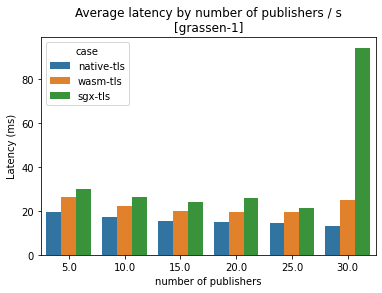

In [12]:
df = latency_per_publishers.rename(columns={'latency': 'Latency (ms)', 'nb_publishers': 'number of publishers'})
df = df[df['number of publishers'] <= 30]
sns.barplot(data=df, x='number of publishers', y='Latency (ms)', hue='case')
plt.title('Average latency by number of publishers / s\n['+ machine + ']')
plt.xlabel('number of publishers')
plt.ylabel('Latency (ms)')


plt.savefig(export_base_path + 'latency_per_number_publishers.png', dpi=300, bbox_inches='tight', transparent = False)

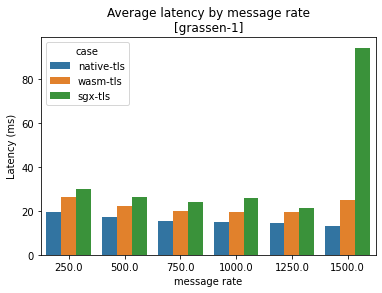

In [13]:
# special graph
df = latency_per_publishers.rename(columns={'latency': 'Latency (ms)', 'nb_publishers': 'number of publishers'})
df['message rate'] = df['number of publishers'] * 50
df = df[df['number of publishers'] <= 30]
sns.barplot(data=df, x='message rate', y='Latency (ms)', hue='case')
plt.title('Average latency by message rate\n['+ machine + ']')
plt.xlabel('message rate')
plt.ylabel('Latency (ms)')

plt.savefig(export_base_path + 'latency_per_message_rate.png', dpi=300, bbox_inches='tight', transparent = False)

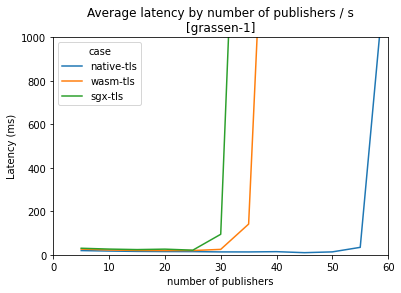

In [14]:
df = latency_per_publishers.rename(columns={'latency': 'Latency (ms)', 'nb_publishers': 'number of publishers'})
#df = df[df['number of publishers'].isin([1, 2, 4, 8, 16, 32, 64])]
df = df.reset_index(drop=True)
sns.lineplot(data=df, x='number of publishers', y='Latency (ms)', hue='case')
plt.title('Average latency by number of publishers / s\n['+ machine + ']')
plt.xlabel('number of publishers')
plt.ylabel('Latency (ms)')

plt.ylim(0, 1000)
plt.xlim(0, 60)

plt.savefig(export_base_path + 'latency_per_number_publishers_lineplot.png', dpi=300, bbox_inches='tight', transparent = False)

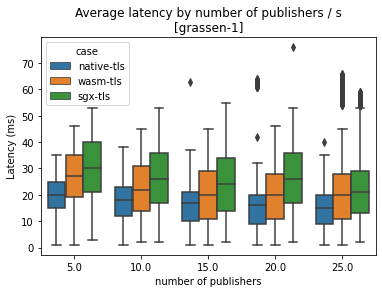

In [24]:
df = cdf_df.rename(columns={'latency': 'Latency (ms)', 'nb_publishers': 'number of publishers'})
df = df[df['number of publishers'] <= 25]
sns.boxplot(data=df, x='number of publishers', y='Latency (ms)', hue='case')
plt.title('Average latency by number of publishers / s\n['+ machine + ']')
plt.xlabel('number of publishers')
plt.ylabel('Latency (ms)')

plt.savefig(export_base_path + 'latency_per_nb_publishers_whisker.png', dpi=300, bbox_inches='tight', transparent = False)

<AxesSubplot:xlabel='nb_publishers', ylabel='payload'>

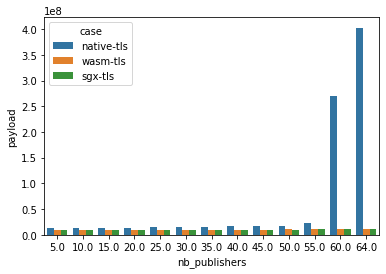

In [16]:
# read heap max
heap_max = pd.DataFrame()
for case in cases:
    df = pd.read_csv(import_base_bath + 'results_' + case + '/heap_max.csv', sep = ';')
    bin_df = bin_dict[case]
    df['nb_publishers'] = 0
    for index, row in bin_df.iterrows():
        # get all messages which have send timestamp between start and end
        start = row['start']
        end = row['end']
        df.loc[(df['timestamp'] >= start) & (df['timestamp'] < end), 'nb_publishers'] = row['bin']
    
    df = df[df['nb_publishers'] != 0]
    df = df.groupby(['nb_publishers']).max()
    df = df.reset_index()
    df['case'] = case
    heap_max = pd.concat([heap_max, df])
df = heap_max
#df = heap_max[heap_max['nb_publishers'].isin([1, 2, 4, 8, 16, 32, 64])]
#df = df[df['case'].isin(['wasm-tls', 'sgx-tls'])]
sns.barplot(data=df, x='nb_publishers', y='payload', hue='case')

In [17]:
nb_publisher_values = cdf_df["nb_publishers"].unique()
toPlot = pd.DataFrame()
for case in cases:
    for nb_pub in nb_publisher_values:
        df = cdf_df[(cdf_df["case"] == case) & (cdf_df["nb_publishers"] == nb_pub)]
        df = df.sort_values(by="latency")
        df = df.reset_index(drop=True)
        n = len(df)
        df['cdf'] = (df.index + 1) / n
        toPlot = pd.concat([toPlot, df])

toPlot = toPlot.reset_index(drop=True)

5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
64.0


<Figure size 432x288 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

<Figure size 442.875x360 with 0 Axes>

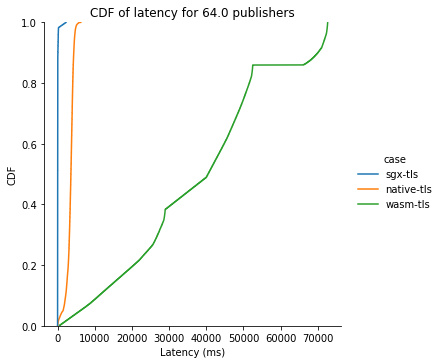

In [18]:
# go through every value of nb_publishers and plot the cdf in a new plot
# all plots together should be one figure (2 rows, 3 plots each row)
for nb_pub in nb_publisher_values:
    # reset the last plt object
    plt.clf()
    print(nb_pub)
    df = toPlot[toPlot["nb_publishers"] == nb_pub]
    #df = df[df["case"].isin(['native-tls', 'native-tls-hw-supp'])]
    df = df.sort_values(by="latency")
    df = df.reset_index(drop=True)
    #sns.lineplot(data=df, x="latency", y="cdf", style="case", dashes=False, markers=True)
    sns.displot(data=df, x="latency", hue="case", kind="ecdf")
    plt.xlabel("Latency (ms)")
    plt.ylabel("CDF")
    plt.title("CDF of latency for " + str(nb_pub) + " publishers")
    plt.savefig(export_base_path + '/cdf_latency_' + str(nb_pub) + '_publishers.png', dpi=300)